## Where is the tracer on the shelf?

This notebook explores the effects of changing the vertical diffusivity (constant, 3D), changing the isopycnal diffusivity in GMREDI and having a canyon vs a flat shelf on the distribution of tracer over the shelf.

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

/home/kramosmu/anaconda/lib/python2.7/site-packages/mpl_toolkits/__init__.py:2: UserWarning: Module MITgcmutils was already imported from MITgcmutils/__init__.pyc, but /home/kramosmu/anaconda/lib/python2.7/site-packages/MITgcmutils-0.1.0-py2.7.egg is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
#Varying-K_iso runs:
CanyonGrid='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/grid.glob.nc'
CanyonGridOut = Dataset(CanyonGrid)
CNTrun13 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/state.0000000000.glob.nc'
StateOut13 = Dataset(CNTrun13)
CNTrun12Tr = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run12/ptracers.0000000000.glob.nc'
CNTrun13Tr = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/ptracers.0000000000.glob.nc'
CNTrun14Tr = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run14/ptracers.0000000000.glob.nc'

#Varying-K_v 3D runs
Kv3Drun01Tr = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/ptracersGlob.nc'
Kv3Drun02Tr = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run02/ptracersGlob.nc'
Kv3Drun03Tr = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run03/ptracersGlob.nc'

#No Canyon run
NoCrun17Tr = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/ptracersGlob.nc'
NoCGrid = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/gridGlob.nc'
NoCGridOut = Dataset(NoCGrid)

#No GMREDI runs
NoREDITr = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_Linprofiles_BarkleyHyd/run02/ptracersGlob.nc'



In [5]:
# General input

nx = 360
ny = 360
nz = 90

nt = 19 # t dimension size 

z = StateOut13.variables['Z']
#print(z[10])
Time = StateOut13.variables['T']
#print(Time[:])
xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

drF = CanyonGridOut.variables['drF'] # vertical distance between faces
dxG = rout.getField(CanyonGrid,'dxG')
bathy = rout.getField(CanyonGrid, 'Depth')

rA = rout.getField(CanyonGrid, 'rA') # area of cells (x-y)
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid,'HFacC') # same for both runs

MaskNoC = rout.getMask(NoCGrid,'HFacC') 
hFacCNoC = rout.getField(NoCGrid,'HFacC') 
rANoC = rout.getField(NoCGrid,'rA') 
drFNoC= NoCGridOut.variables['drF']

In [6]:
# Load tracers variable K_iso
Tr1Iso10 = rout.getField(CNTrun12Tr,'Tr1') # Tracer 1 CNT run12 , Kz = E-5
Tr2Iso10 = rout.getField(CNTrun12Tr,'Tr2') # Tracer 2 CNT run12 , Kz = E-3
Tr1Iso1 = rout.getField(CNTrun13Tr,'Tr1') # Tracer 1 CNT run13 , Kz = E-5
Tr2Iso1 = rout.getField(CNTrun13Tr,'Tr2') # Tracer 2 CNT run13 , Kz = E-3
Tr1Iso01 = rout.getField(CNTrun14Tr,'Tr1') # Tracer 1 CNT run14 , Kz = E-5
Tr2Iso01 = rout.getField(CNTrun14Tr,'Tr2') # Tracer 2 CNT run14 , Kz = E-3



In [7]:
# Load tracers variable K_v
Tr13D = rout.getField(Kv3Drun01Tr,'Tr1') # Tracer 1 3D run01 , Kz = E-7 out, E-3 in
Tr23D = rout.getField(Kv3Drun02Tr,'Tr1') # Tracer 1 3D run02 , Kz = E-7 out, E-4 in
Tr33D = rout.getField(Kv3Drun03Tr,'Tr1') # Tracer 1 3D run03 , Kz = E-5 out, E-3 in


In [8]:
# Load tracers of no canyon run
Tr1NoC = rout.getField(NoCrun17Tr,'Tr1') # Tracer 1 NoC run17CNT , Kz = E-5
Tr2NoC = rout.getField(NoCrun17Tr,'Tr2') # Tracer 2 NoC run17CNT , Kz = E-3 


In [9]:
# Load tracers of no canyon run
Tr1NoREDI = rout.getField(NoREDITr,'Tr1') # Tracer 1 NoREDI run02 , Kz = E-5
Tr2NoREDI = rout.getField(NoREDITr,'Tr2') # Tracer 2 NoREDI run02 , Kz = E-4 
Tr3NoREDI = rout.getField(NoREDITr,'Tr3') # Tracer 3 NoREDI run02 , Kz = E-3 



### How much water with concentration higher than a limit is there along the shelf? How much tracer mass along the shelf?

In [10]:
def HowMuchWaterX(Tr,MaskC,nzlim,rA,hFacC,drF,tt,nx,dx):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    tt    : Time slice to calculate. Int 0<=tt<19
    nx    : x dimension (along shelf) 
    dx    : 
    OUTPUT----------------------------------------------------------------------------------------------------------------
    WaterX = (360) Arrays with the volume of water at each x-position over the shelf [tt,:28,:197,xx]
    TrX = (360) Arrays with the mass of tracer (umol) at each x-position over the shelf [tt,:28,:197,xx]. 
          Total mass of tracer at xx on the shelf.
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''
    WaterX= np.zeros(nx)
    TrX= np.zeros(nx)
  
    TrMask0=np.ma.array(Tr[0,:,:,:],mask=MaskC[:,:,:])
        
    trlim = TrMask0[nzlim,50,180]
    
    hFacCSwap = np.swapaxes(hFacC, 0, 2)
    
    #print('tracer limit is: ',trlim)
    
    TrMask=np.ma.array(Tr[tt,:,:,:],mask=MaskC[:,:,:])
    
    for ii,trac in np.ndenumerate(TrMask[:28,197:,:]) :
        if trac >= trlim:
             WaterX[ii[2]] = WaterX[ii[2]] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]/dx[ii[1],ii[2]]
                
                
    VolX = (np.swapaxes(hFacCSwap[:,197:,:28]*drF[:28],0,2))*rA[197:,:]
          
    TrX[:] = np.sum(np.sum((VolX*TrMask[:28,197:,:]*1000.0),axis=0),axis=0)/dx[0,:] #[1 umol/l=1000 umol/m^3]
     
    
    
    return(WaterX,TrX)

### Case 1: Changing $K_{iso}$ in GMREDI

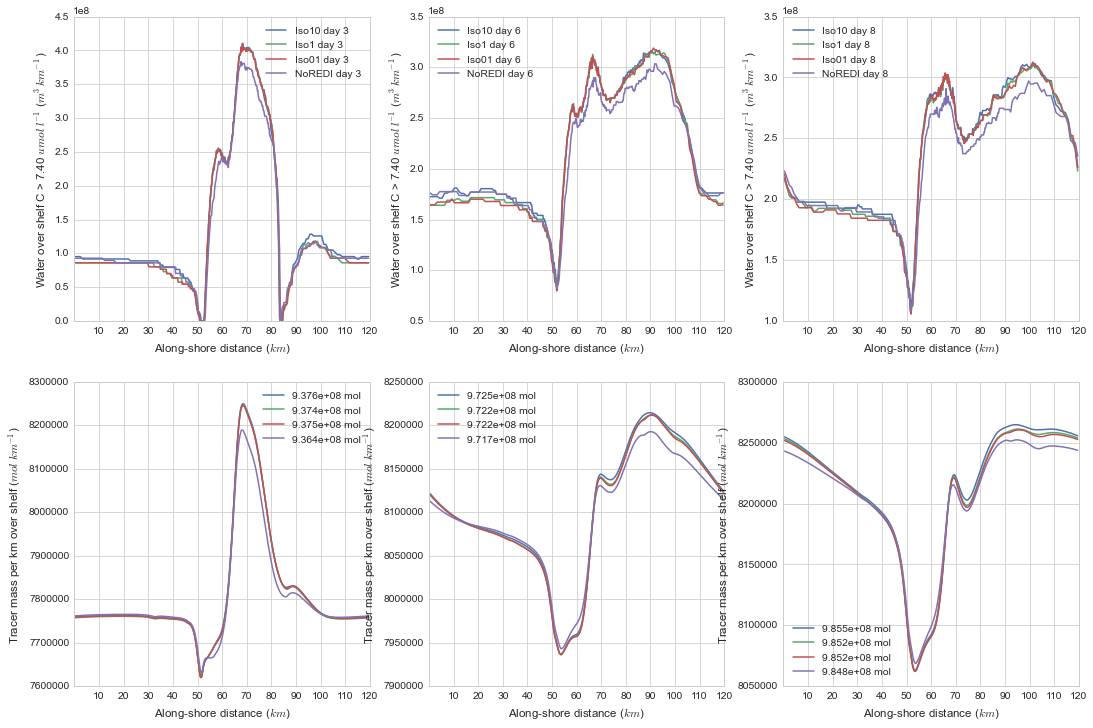

In [11]:
fig45=plt.figure(figsize=(18,12))
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=1.3, rc={"lines.linewidth": 1.5})


time = 6
(WaterXIso10, Tr1XIso10) = HowMuchWaterX(Tr1Iso10,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterXIso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterXIso01, Tr1XIso01) = HowMuchWaterX(Tr1Iso01,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
(WaterXNoREDI, Tr1XNoREDI) = HowMuchWaterX(Tr1NoREDI,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax1 = plt.subplot(2,3,1)
ax1.plot(xc[0,:],(WaterXIso10)*1000.0,'-',label=('Iso10 day %d' %(time/2.0))) # 1000m/km
ax1.plot(xc[0,:],(WaterXIso1)*1000.0,'-',label=('Iso1 day %d' %(time/2.0)))
ax1.plot(xc[0,:],(WaterXIso01)*1000.0,'-',label=('Iso01 day %d' %(time/2.0)))
ax1.plot(xc[0,:],(WaterXNoREDI)*1000.0,'-',label=('NoREDI day %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax4 = plt.subplot(2,3,4)
ax4.plot(xc[0,:],(Tr1XIso10)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso10)*dxG[0,:]*1.E-6)))) # 1000m/km
ax4.plot(xc[0,:],(Tr1XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1)*dxG[0,:]*1.E-6))))
ax4.plot(xc[0,:],(Tr1XIso01)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso01)*dxG[0,:]*1.E-6))))
ax4.plot(xc[0,:],(Tr1XNoREDI)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XNoREDI)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)



time = 12
(WaterXIso10, Tr1XIso10) = HowMuchWaterX(Tr1Iso10,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterXIso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterXIso01, Tr1XIso01) = HowMuchWaterX(Tr1Iso01,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
(WaterXNoREDI, Tr1XNoREDI) = HowMuchWaterX(Tr1NoREDI,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax2 = plt.subplot(2,3,2)
ax2.plot(xc[0,:],(WaterXIso10)*1000.0,'-',label=('Iso10 day %d' %(time/2.0))) # 1000m/km
ax2.plot(xc[0,:],(WaterXIso1)*1000.0,'-',label=('Iso1 day %d' %(time/2.0)))
ax2.plot(xc[0,:],(WaterXIso01)*1000.0,'-',label=('Iso01 day %d' %(time/2.0)))
ax2.plot(xc[0,:],(WaterXNoREDI)*1000.0,'-',label=('NoREDI day %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#plt.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax5 = plt.subplot(2,3,5)
ax5.plot(xc[0,:],(Tr1XIso10)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso10)*dxG[0,:]*1.E-6)))) # 1000m/km
ax5.plot(xc[0,:],(Tr1XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1)*dxG[0,:]*1.E-6))))
ax5.plot(xc[0,:],(Tr1XIso01)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso01)*dxG[0,:]*1.E-6))))
ax5.plot(xc[0,:],(Tr1XNoREDI)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XNoREDI)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)



time = 16
(WaterXIso10, Tr1XIso10) = HowMuchWaterX(Tr1Iso10,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterXIso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterXIso01, Tr1XIso01) = HowMuchWaterX(Tr1Iso01,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
(WaterXNoREDI, Tr1XNoREDI) = HowMuchWaterX(Tr1NoREDI,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax3 = plt.subplot(2,3,3)
ax3.plot(xc[0,:],(WaterXIso10)*1000.0,'-',label=('Iso10 day %d' %(time/2.0))) # 1000m/km
ax3.plot(xc[0,:],(WaterXIso1)*1000.0,'-',label=('Iso1 day %d' %(time/2.0)))
ax3.plot(xc[0,:],(WaterXIso01)*1000.0,'-',label=('Iso01 day %d' %(time/2.0)))
ax3.plot(xc[0,:],(WaterXNoREDI)*1000.0,'-',label=('NoREDI day %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#plt.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax6 = plt.subplot(2,3,6)
ax6.plot(xc[0,:],(Tr1XIso10)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso10)*dxG[0,:]*1.E-6)))) # 1000m/km
ax6.plot(xc[0,:],(Tr1XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1)*dxG[0,:]*1.E-6))))
ax6.plot(xc[0,:],(Tr1XIso01)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso01)*dxG[0,:]*1.E-6))))
ax6.plot(xc[0,:],(Tr1XNoREDI)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XNoREDI)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

       
#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/H20TrPerKm3DCNT1-NoC1.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')




### Case 2: Enhanced mixing inside the canyon (3D vertical diffusivity)


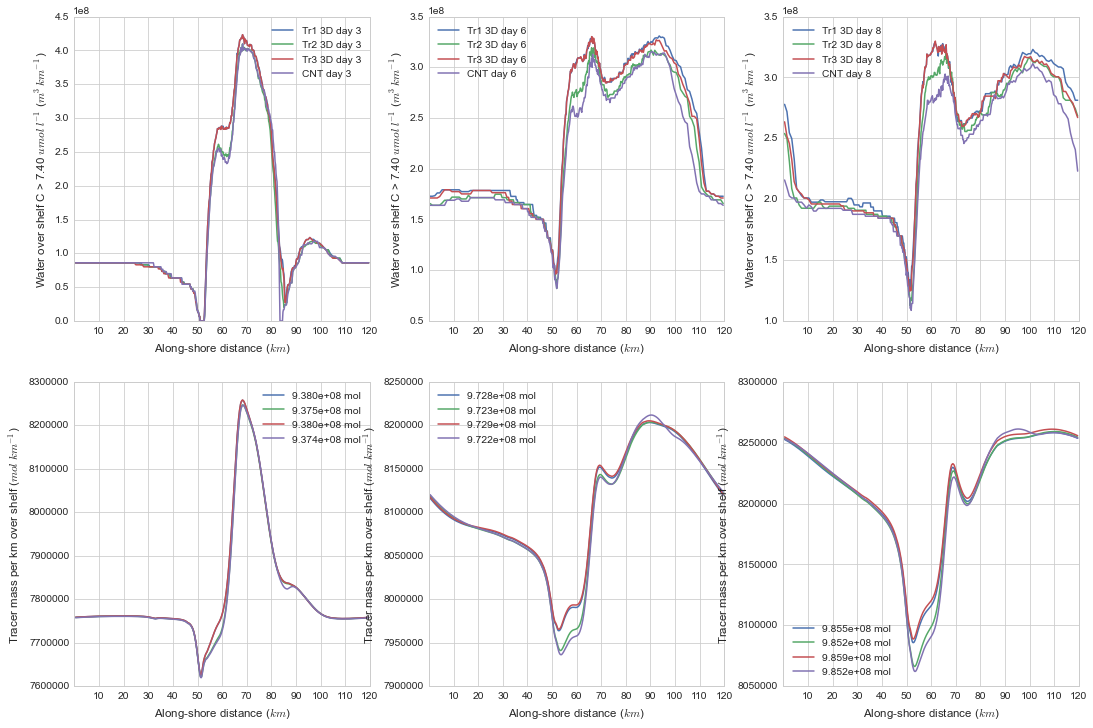

In [12]:
fig45=plt.figure(figsize=(18,12))
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=1.3, rc={"lines.linewidth": 1.5})


time = 6
(WaterX3D1, Tr1X3D) = HowMuchWaterX(Tr13D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX3D2, Tr2X3D) = HowMuchWaterX(Tr23D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX3D3, Tr3X3D) = HowMuchWaterX(Tr33D,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX1Iso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax1 = plt.subplot(2,3,1)
ax1.plot(xc[0,:],(WaterX3D1)*1000.0,'-',label=('Tr1 3D day %d' %(time/2.0))) # 1000m/km
ax1.plot(xc[0,:],(WaterX3D2)*1000.0,'-',label=('Tr2 3D day %d' %(time/2.0)))
ax1.plot(xc[0,:],(WaterX3D3)*1000.0,'-',label=('Tr3 3D day %d' %(time/2.0)))
ax1.plot(xc[0,:],(WaterX1Iso1)*1000.0,'-',label=('CNT day %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax4 = plt.subplot(2,3,4)
ax4.plot(xc[0,:],(Tr1X3D)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1X3D)*dxG[0,:]*1.E-6)))) # 1000m/km
ax4.plot(xc[0,:],(Tr2X3D)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr2X3D)*dxG[0,:]*1.E-6))))
ax4.plot(xc[0,:],(Tr3X3D)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr3X3D)*dxG[0,:]*1.E-6))))
ax4.plot(xc[0,:],(Tr1XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)



time = 12
(WaterX3D1, Tr1X3D) = HowMuchWaterX(Tr13D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX3D2, Tr2X3D) = HowMuchWaterX(Tr23D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX3D3, Tr3X3D) = HowMuchWaterX(Tr33D,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX1Iso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax2 = plt.subplot(2,3,2)
ax2.plot(xc[0,:],(WaterX3D1)*1000.0,'-',label=('Tr1 3D day %d' %(time/2.0))) # 1000m/km
ax2.plot(xc[0,:],(WaterX3D2)*1000.0,'-',label=('Tr2 3D day %d' %(time/2.0)))
ax2.plot(xc[0,:],(WaterX3D3)*1000.0,'-',label=('Tr3 3D day %d' %(time/2.0)))
ax2.plot(xc[0,:],(WaterX1Iso1)*1000.0,'-',label=('CNT day %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#plt.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax5 = plt.subplot(2,3,5)
ax5.plot(xc[0,:],(Tr1X3D)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1X3D)*dxG[0,:]*1.E-6)))) # 1000m/km
ax5.plot(xc[0,:],(Tr2X3D)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr2X3D)*dxG[0,:]*1.E-6))))
ax5.plot(xc[0,:],(Tr3X3D)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr3X3D)*dxG[0,:]*1.E-6))))
ax5.plot(xc[0,:],(Tr1XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)



time = 16
(WaterX3D1, Tr1X3D) = HowMuchWaterX(Tr13D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX3D2, Tr2X3D) = HowMuchWaterX(Tr23D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX3D3, Tr3X3D) = HowMuchWaterX(Tr33D,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX1Iso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax3 = plt.subplot(2,3,3)
ax3.plot(xc[0,:],(WaterX3D1)*1000.0,'-',label=('Tr1 3D day %d' %(time/2.0))) # 1000m/km
ax3.plot(xc[0,:],(WaterX3D2)*1000.0,'-',label=('Tr2 3D day %d' %(time/2.0)))
ax3.plot(xc[0,:],(WaterX3D3)*1000.0,'-',label=('Tr3 3D day %d' %(time/2.0)))
ax3.plot(xc[0,:],(WaterX1Iso1)*1000.0,'-',label=('CNT day %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#plt.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax6 = plt.subplot(2,3,6)
ax6.plot(xc[0,:],(Tr1X3D)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1X3D)*dxG[0,:]*1.E-6)))) # 1000m/km
ax6.plot(xc[0,:],(Tr2X3D)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr2X3D)*dxG[0,:]*1.E-6))))
ax6.plot(xc[0,:],(Tr3X3D)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr3X3D)*dxG[0,:]*1.E-6))))
ax6.plot(xc[0,:],(Tr1XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

       
#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/H20TrPerKm3DCNT1-NoC1.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')






### Case 3: Varying Kv and flat shelf 

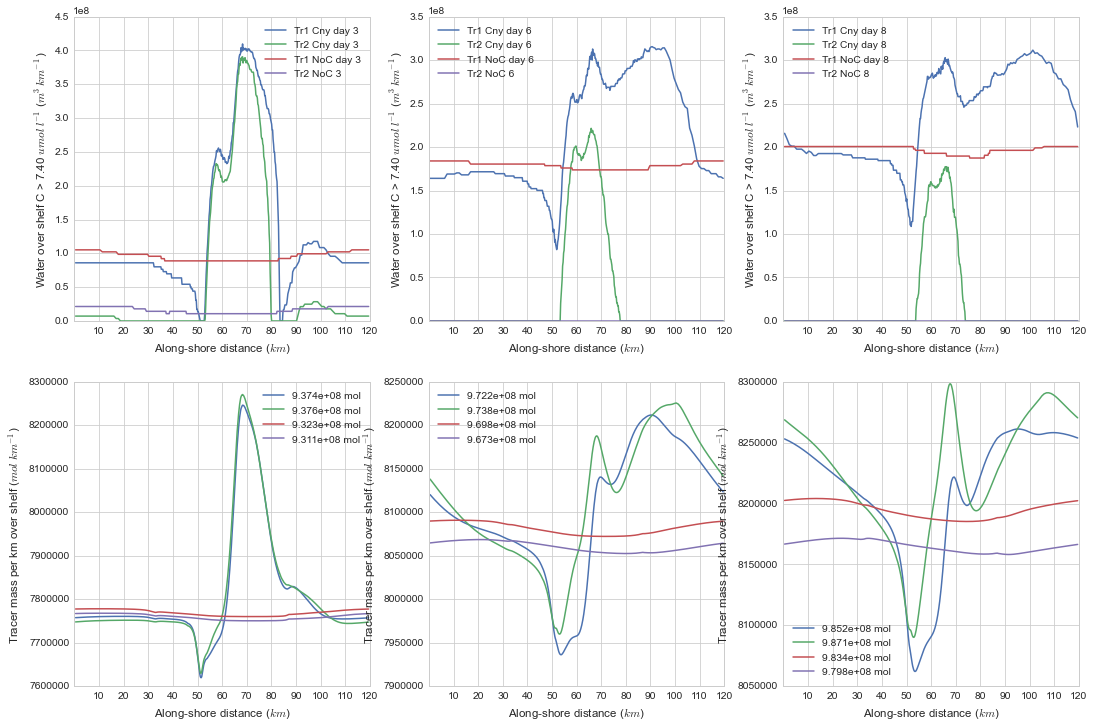

In [13]:
fig45=plt.figure(figsize=(18,12))
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=1.3, rc={"lines.linewidth": 1.5})


time = 6
(WaterX1Iso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX2Iso1, Tr2XIso1) = HowMuchWaterX(Tr2Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX1NoC, Tr1XNoC) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX2NoC, Tr2XNoC) = HowMuchWaterX(Tr2NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax1 = plt.subplot(2,3,1)
ax1.plot(xc[0,:],(WaterX1Iso1)*1000.0,'-',label=('Tr1 Cny day %d' %(time/2.0))) # 1000m/km
ax1.plot(xc[0,:],(WaterX2Iso1)*1000.0,'-',label=('Tr2 Cny day %d' %(time/2.0)))
ax1.plot(xc[0,:],(WaterX1NoC)*1000.0,'-',label=('Tr1 NoC day %d' %(time/2.0)))
ax1.plot(xc[0,:],(WaterX2NoC)*1000.0,'-',label=('Tr2 NoC %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax4 = plt.subplot(2,3,4)
ax4.plot(xc[0,:],(Tr1XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1)*dxG[0,:]*1.E-6)))) # 1000m/km
ax4.plot(xc[0,:],(Tr2XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr2XIso1)*dxG[0,:]*1.E-6))))
ax4.plot(xc[0,:],(Tr1XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XNoC)*dxG[0,:]*1.E-6))))
ax4.plot(xc[0,:],(Tr2XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr2XNoC)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)



time = 12
(WaterX1Iso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX2Iso1, Tr2XIso1) = HowMuchWaterX(Tr2Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX1NoC, Tr1XNoC) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX2NoC, Tr2XNoC) = HowMuchWaterX(Tr2NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax2 = plt.subplot(2,3,2)
ax2.plot(xc[0,:],(WaterX1Iso1)*1000.0,'-',label=('Tr1 Cny day %d' %(time/2.0))) # 1000m/km
ax2.plot(xc[0,:],(WaterX2Iso1)*1000.0,'-',label=('Tr2 Cny day %d' %(time/2.0)))
ax2.plot(xc[0,:],(WaterX1NoC)*1000.0,'-',label=('Tr1 NoC day %d' %(time/2.0)))
ax2.plot(xc[0,:],(WaterX2NoC)*1000.0,'-',label=('Tr2 NoC %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#plt.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax5 = plt.subplot(2,3,5)
ax5.plot(xc[0,:],(Tr1XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1)*dxG[0,:]*1.E-6)))) # 1000m/km
ax5.plot(xc[0,:],(Tr2XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr2XIso1)*dxG[0,:]*1.E-6))))
ax5.plot(xc[0,:],(Tr1XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XNoC)*dxG[0,:]*1.E-6))))
ax5.plot(xc[0,:],(Tr2XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr2XNoC)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)



time = 16
(WaterX1Iso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX2Iso1, Tr2XIso1) = HowMuchWaterX(Tr2Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX1NoC, Tr1XNoC) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX2NoC, Tr2XNoC) = HowMuchWaterX(Tr2NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax3 = plt.subplot(2,3,3)
ax3.plot(xc[0,:],(WaterX1Iso1)*1000.0,'-',label=('Tr1 Cny day %d' %(time/2.0))) # 1000m/km
ax3.plot(xc[0,:],(WaterX2Iso1)*1000.0,'-',label=('Tr2 Cny day %d' %(time/2.0)))
ax3.plot(xc[0,:],(WaterX1NoC)*1000.0,'-',label=('Tr1 NoC day %d' %(time/2.0)))
ax3.plot(xc[0,:],(WaterX2NoC)*1000.0,'-',label=('Tr2 NoC %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#plt.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax6 = plt.subplot(2,3,6)
ax6.plot(xc[0,:],(Tr1XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1)*dxG[0,:]*1.E-6)))) # 1000m/km
ax6.plot(xc[0,:],(Tr2XIso1)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr2XIso1)*dxG[0,:]*1.E-6))))
ax6.plot(xc[0,:],(Tr1XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XNoC)*dxG[0,:]*1.E-6))))
ax6.plot(xc[0,:],(Tr2XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr2XNoC)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

       
#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/H20TrPerKm3DCNT1-NoC1.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')






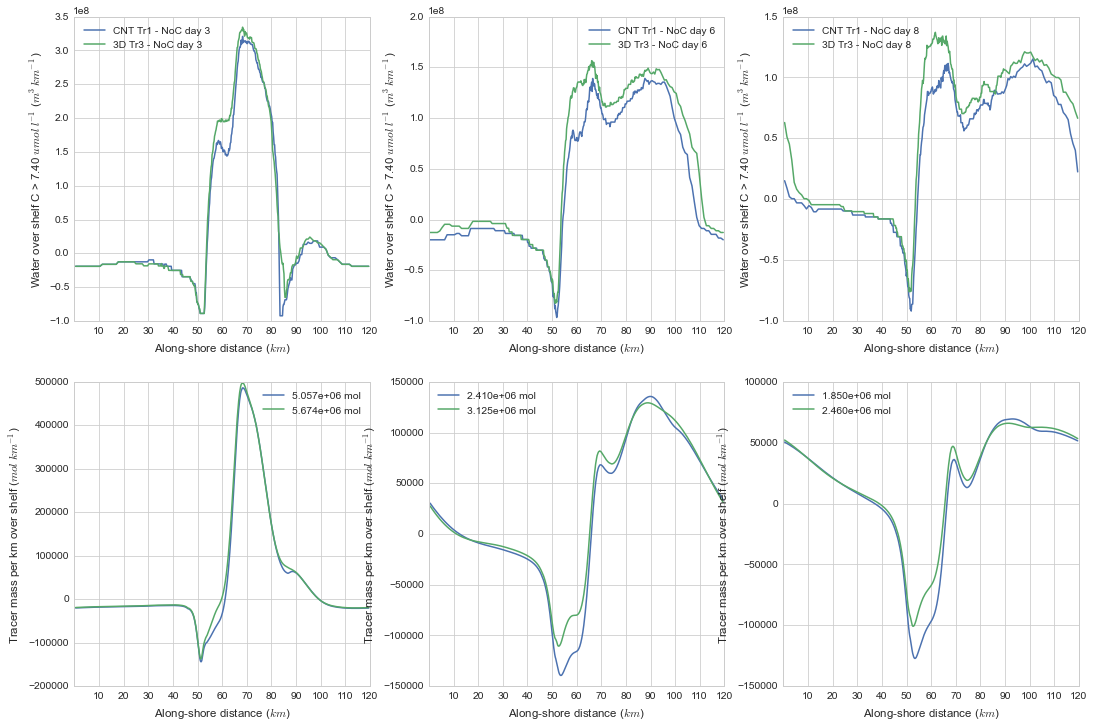

In [16]:
fig45=plt.figure(figsize=(18,12))
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=1.3, rc={"lines.linewidth": 1.5})


time = 6
(WaterX1Iso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX33D, Tr3X3D) = HowMuchWaterX(Tr33D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX1NoC, Tr1XNoC) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax1 = plt.subplot(2,3,1)
ax1.plot(xc[0,:],(WaterX1Iso1-WaterX1NoC)*1000.0,'-',label=('CNT Tr1 - NoC day %d' %(time/2.0))) # 1000m/km
ax1.plot(xc[0,:],(WaterX33D-WaterX1NoC)*1000.0,'-',label=('3D Tr3 - NoC day %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax4 = plt.subplot(2,3,4)
ax4.plot(xc[0,:],(Tr1XIso1-Tr1XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1-Tr1XNoC)*dxG[0,:]*1.E-6)))) # 1000m/km
ax4.plot(xc[0,:],(Tr3X3D - Tr1XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr3X3D - Tr1XNoC)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)



time = 12
(WaterX1Iso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX33D, Tr3X3D) = HowMuchWaterX(Tr33D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX1NoC, Tr1XNoC) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax2 = plt.subplot(2,3,2)
ax2.plot(xc[0,:],(WaterX1Iso1-WaterX1NoC)*1000.0,'-',label=('CNT Tr1 - NoC day %d' %(time/2.0))) # 1000m/km
ax2.plot(xc[0,:],(WaterX33D-WaterX1NoC)*1000.0,'-',label=('3D Tr3 - NoC day %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#plt.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax5 = plt.subplot(2,3,5)
ax5.plot(xc[0,:],(Tr1XIso1-Tr1XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1-Tr1XNoC)*dxG[0,:]*1.E-6)))) # 1000m/km
ax5.plot(xc[0,:],(Tr3X3D - Tr1XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr3X3D - Tr1XNoC)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)



time = 16
(WaterX1Iso1, Tr1XIso1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX33D, Tr3X3D) = HowMuchWaterX(Tr33D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
(WaterX1NoC, Tr1XNoC) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

ax3 = plt.subplot(2,3,3)
ax3.plot(xc[0,:],(WaterX1Iso1-WaterX1NoC)*1000.0,'-',label=('CNT Tr1 - NoC day %d' %(time/2.0))) # 1000m/km
ax3.plot(xc[0,:],(WaterX33D-WaterX1NoC)*1000.0,'-',label=('3D Tr3 - NoC day %d' %(time/2.0)))

plt.ylabel('Water over shelf C > 7.40 $umol$ $l^{-1}$ ($m^3 km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#plt.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

ax6 = plt.subplot(2,3,6)
ax6.plot(xc[0,:],(Tr1XIso1-Tr1XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr1XIso1-Tr1XNoC)*dxG[0,:]*1.E-6)))) # 1000m/km
ax6.plot(xc[0,:],(Tr3X3D - Tr1XNoC)*1.E-3,'-',label=('%.3e mol' %(np.sum((Tr3X3D - Tr1XNoC)*dxG[0,:]*1.E-6))))

plt.ylabel('Tracer mass per km over shelf ($mol$ $km^{-1}$)')
plt.xlabel('Along-shore distance ($km$)')
labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
#ax2.title = ('day %d' %(time/2.0))
plt.legend(loc=0)

       
#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/H20TrPerKm3DCNT1-NoC1.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')




